
---
# 02. Przetwarzanie Danych NYC Taxi 2016

Ten notebook zawiera czyszczenie danych, feature engineering oraz zapis agregatów do MongoDB.
---

In [1]:
import sys
sys.path.append('/home/jovyan')

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import DataLoader
from src.preprocessing import DataPreprocessor
from src.features import FeatureEngineer
from config.spark_config import (
    MONGODB_CONFIG, DATA_PATHS, 
    PAYMENT_TYPES, DAY_NAMES, MONTH_NAMES
)

plt.style.use('seaborn-v0_8-whitegrid')
print("Biblioteki załadowane!")


Biblioteki załadowane!


## 2.1 Wczytanie Danych

In [2]:
# %% Inicjalizacja
loader = DataLoader()
df_raw = loader.load_data()
print(f"Wczytano {df_raw.count():,} rekordów")

Tworzenie sesji Spark...
Spark UI: http://localhost:4040
Master: local[*]
Spark Version: 3.5.0
Python Version: 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]

Wczytywanie danych z: /home/jovyan/data/yellow_tripdata_2015-*.csv
⚠️  UWAGA: Nie znaleziono plików pasujących do wzorca: /home/jovyan/data/yellow_tripdata_2015-*.csv
Upewnij się, że pliki CSV znajdują się w folderze 'data/'
✓ Wczytano 12,748,986 rekordów w 9.00 sekund
Wczytano 12,748,986 rekordów


## 2.2 Czyszczenie Danych

In [3]:
# %% Czyszczenie
preprocessor = DataPreprocessor()
df_cleaned = preprocessor.clean_data(df_raw)

# %% Statystyki czyszczenia
stats = preprocessor.get_cleaning_stats()
print(f"\nUsunięto {stats['removed_pct']:.2f}% danych")


CZYSZCZENIE DANYCH (początkowa liczba: 12,748,986)
  Przed: 12,748,986
  Po:    12,418,683
  Usunięto: 330,303 (2.59%)

Usunięto 2.59% danych


## 2.3 Feature Engineering

In [4]:
# %% Tworzenie cech
feature_engineer = FeatureEngineer()
df_features = feature_engineer.create_all_features(df_cleaned)

# Cache dla wydajności
df_features.cache()
final_count = df_features.count()
print(f"\nFinalna liczba rekordów: {final_count:,}")

# %% Podgląd nowych cech
print("\nNOWE CECHY:")
df_features.select(
    "trip_distance", "trip_duration_min", "speed_mph",
    "pickup_hour", "pickup_day", "is_weekend", "is_rush_hour",
    "tip_percentage", "high_tip", "time_of_day"
).show(10)



TWORZENIE NOWYCH CECH...
Utworzono cechy:
  - Czasowe: pickup_hour, pickup_day, pickup_month, is_weekend, is_rush_hour, is_night
  - Przejazdu: trip_duration_min, speed_mph, distance_category
  - Napiwków: tip_percentage, high_tip

Finalna liczba rekordów: 12,401,881

NOWE CECHY:
+-------------+------------------+------------------+-----------+----------+----------+------------+------------------+--------+-----------+
|trip_distance| trip_duration_min|         speed_mph|pickup_hour|pickup_day|is_weekend|is_rush_hour|    tip_percentage|high_tip|time_of_day|
+-------------+------------------+------------------+-----------+----------+----------+------------+------------------+--------+-----------+
|          1.3| 8.633333333333333| 9.034749034749035|         20|         6|         0|           0|               0.0|       0|    evening|
|         1.64|19.416666666666668| 5.067811158798283|         19|         6|         0|           1|26.923076923076923|       1|    evening|
|          2.

## 2.4 Zapis do MongoDB

In [5]:

# %% Połączenie z MongoDB
print("\nŁączenie z MongoDB...")
client = MongoClient(MONGODB_CONFIG["uri"])
db = client[MONGODB_CONFIG["database"]]
print(f"Połączono z bazą: {db.name}")


Łączenie z MongoDB...
Połączono z bazą: nyc_taxi


In [7]:
# %% Agregacja 1: Statystyki godzinowe
print("\nObliczanie i zapisywanie agregatów...")

hourly_stats = df_features.groupBy("pickup_hour").agg(
    count("*").alias("trip_count"),
    avg("fare_amount").alias("avg_fare"),
    avg("tip_percentage").alias("avg_tip_pct"),
    avg("trip_distance").alias("avg_distance"),
    avg("trip_duration_min").alias("avg_duration"),
    sum("high_tip").alias("high_tip_count"),
    (sum("high_tip") / count("*") * 100).alias("high_tip_rate")
).orderBy("pickup_hour")

hourly_stats_pd = hourly_stats.toPandas()
db.hourly_stats.drop()
db.hourly_stats.insert_many(hourly_stats_pd.to_dict('records'))
print(f"  ✓ hourly_stats: {db.hourly_stats.count_documents({})} dokumentów")

# %% Agregacja 2: Statystyki dzienne
daily_stats = df_features.groupBy("pickup_day").agg(
    count("*").alias("trip_count"),
    avg("fare_amount").alias("avg_fare"),
    avg("tip_percentage").alias("avg_tip_pct"),
    avg("trip_distance").alias("avg_distance"),
    sum("total_amount").alias("total_revenue")
).orderBy("pickup_day")

daily_stats_pd = daily_stats.toPandas()
daily_stats_pd["day_name"] = daily_stats_pd["pickup_day"].map(DAY_NAMES)

db.daily_stats.drop()
db.daily_stats.insert_many(daily_stats_pd.to_dict('records'))
print(f"  ✓ daily_stats: {db.daily_stats.count_documents({})} dokumentów")

# %% Agregacja 3: Statystyki miesięczne
monthly_stats = df_features.groupBy("pickup_month").agg(
    count("*").alias("trip_count"),
    avg("fare_amount").alias("avg_fare"),
    avg("tip_percentage").alias("avg_tip_pct"),
    sum("total_amount").alias("total_revenue"),
    avg("passenger_count").alias("avg_passengers")
).orderBy("pickup_month")

monthly_stats_pd = monthly_stats.toPandas()
db.monthly_stats.drop()
db.monthly_stats.insert_many(monthly_stats_pd.to_dict('records'))
print(f"  ✓ monthly_stats: {db.monthly_stats.count_documents({})} dokumentów")

# %% Agregacja 4: Statystyki płatności
payment_stats = df_features.groupBy("payment_type").agg(
    count("*").alias("trip_count"),
    avg("fare_amount").alias("avg_fare"),
    avg("tip_amount").alias("avg_tip"),
    avg("tip_percentage").alias("avg_tip_pct"),
    sum("total_amount").alias("total_revenue")
).orderBy("payment_type")

payment_stats_pd = payment_stats.toPandas()
payment_stats_pd["payment_name"] = payment_stats_pd["payment_type"].map(PAYMENT_TYPES)

db.payment_stats.drop()
db.payment_stats.insert_many(payment_stats_pd.to_dict('records'))
print(f"  ✓ payment_stats: {db.payment_stats.count_documents({})} dokumentów")

# %% Agregacja 5: Statystyki dystansu
distance_stats = df_features.groupBy("distance_category").agg(
    count("*").alias("trip_count"),
    avg("fare_amount").alias("avg_fare"),
    avg("trip_duration_min").alias("avg_duration"),
    avg("tip_percentage").alias("avg_tip_pct"),
    avg("speed_mph").alias("avg_speed")
)

distance_stats_pd = distance_stats.toPandas()
db.distance_stats.drop()
db.distance_stats.insert_many(distance_stats_pd.to_dict('records'))
print(f"  ✓ distance_stats: {db.distance_stats.count_documents({})} dokumentów")



Obliczanie i zapisywanie agregatów...
  ✓ hourly_stats: 24 dokumentów
  ✓ daily_stats: 7 dokumentów
  ✓ monthly_stats: 1 dokumentów
  ✓ payment_stats: 4 dokumentów
  ✓ distance_stats: 4 dokumentów


In [8]:
print("\n" + "=" * 50)
print("PODSUMOWANIE MongoDB")
print("=" * 50)
for coll in db.list_collection_names():
    print(f"  {coll}: {db[coll].count_documents({})} dokumentów")


PODSUMOWANIE MongoDB
  model_results: 1 dokumentów
  payment_stats: 4 dokumentów
  hourly_stats: 24 dokumentów
  daily_stats: 7 dokumentów
  monthly_stats: 1 dokumentów
  distance_stats: 4 dokumentów


## 2.5 Wizualizacje Danych Przetworzonych

Próbka do wizualizacji: 100,045


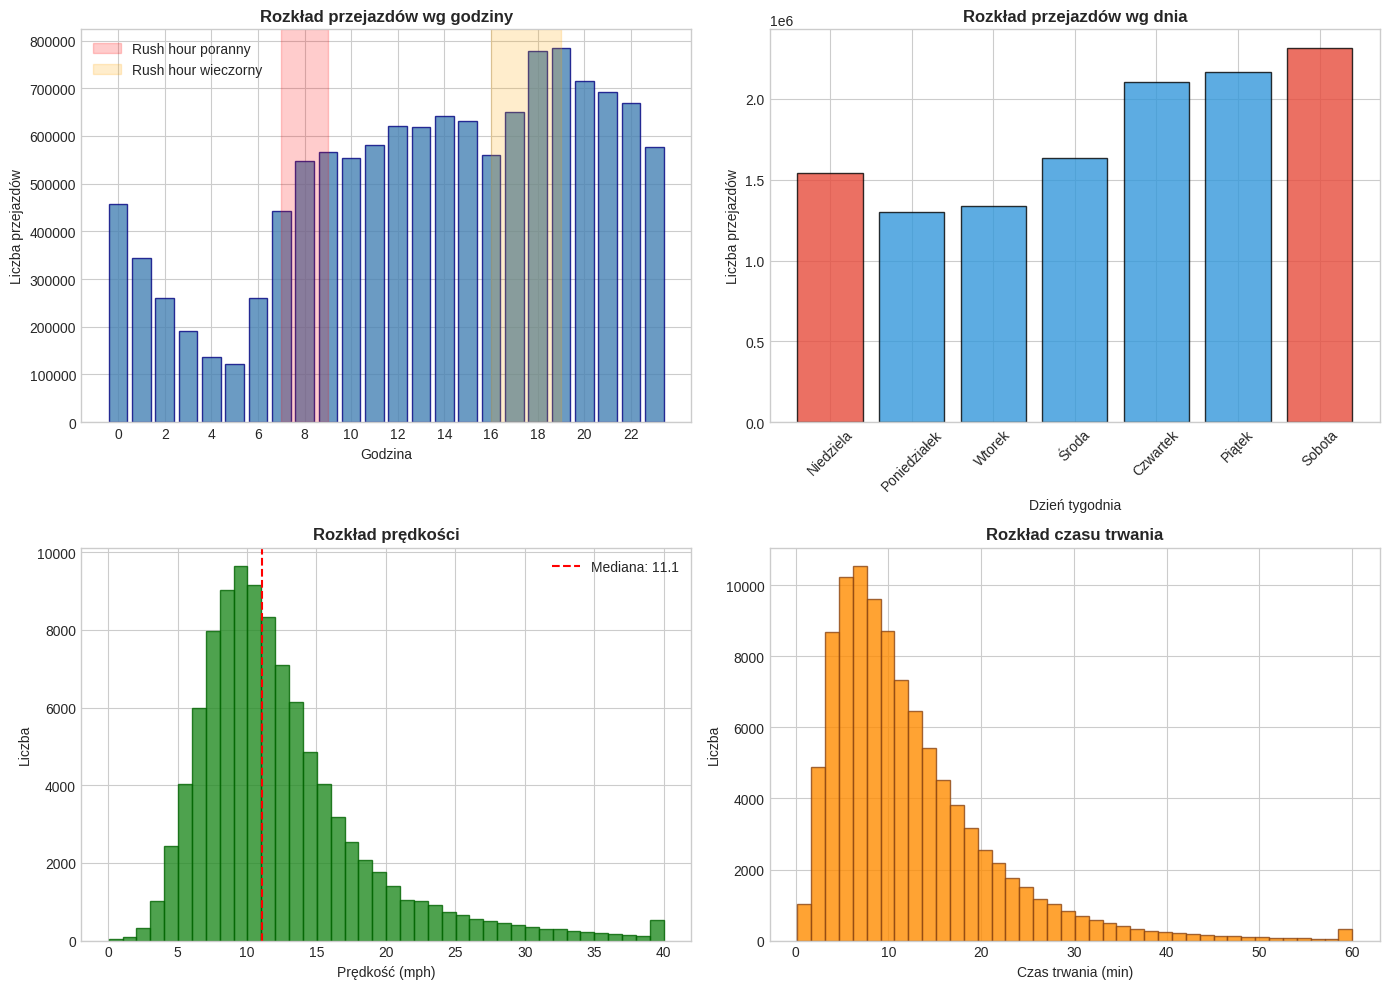

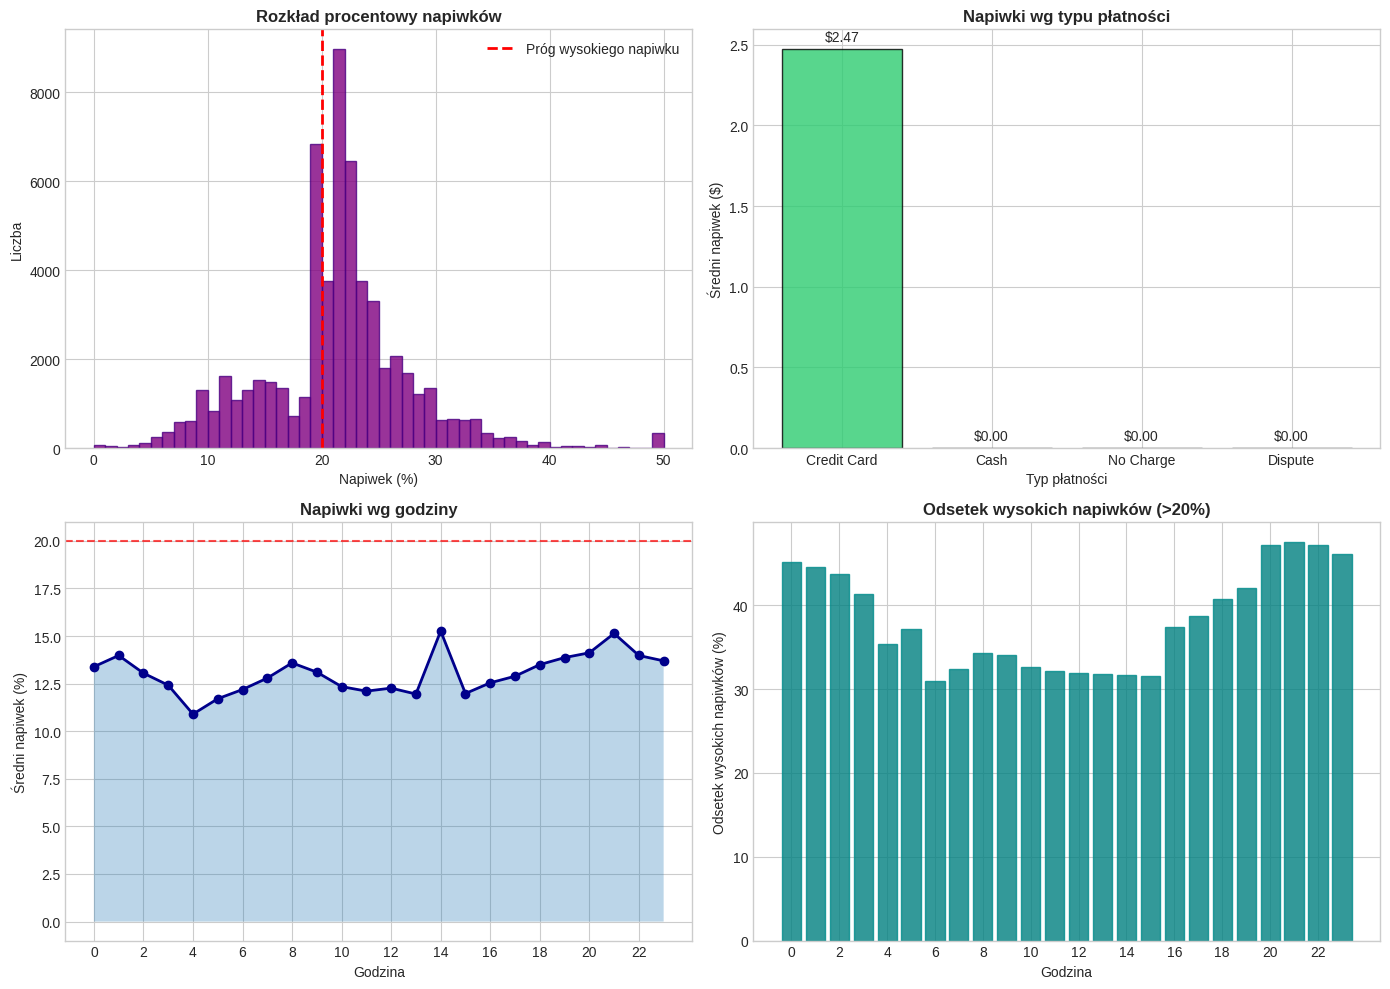

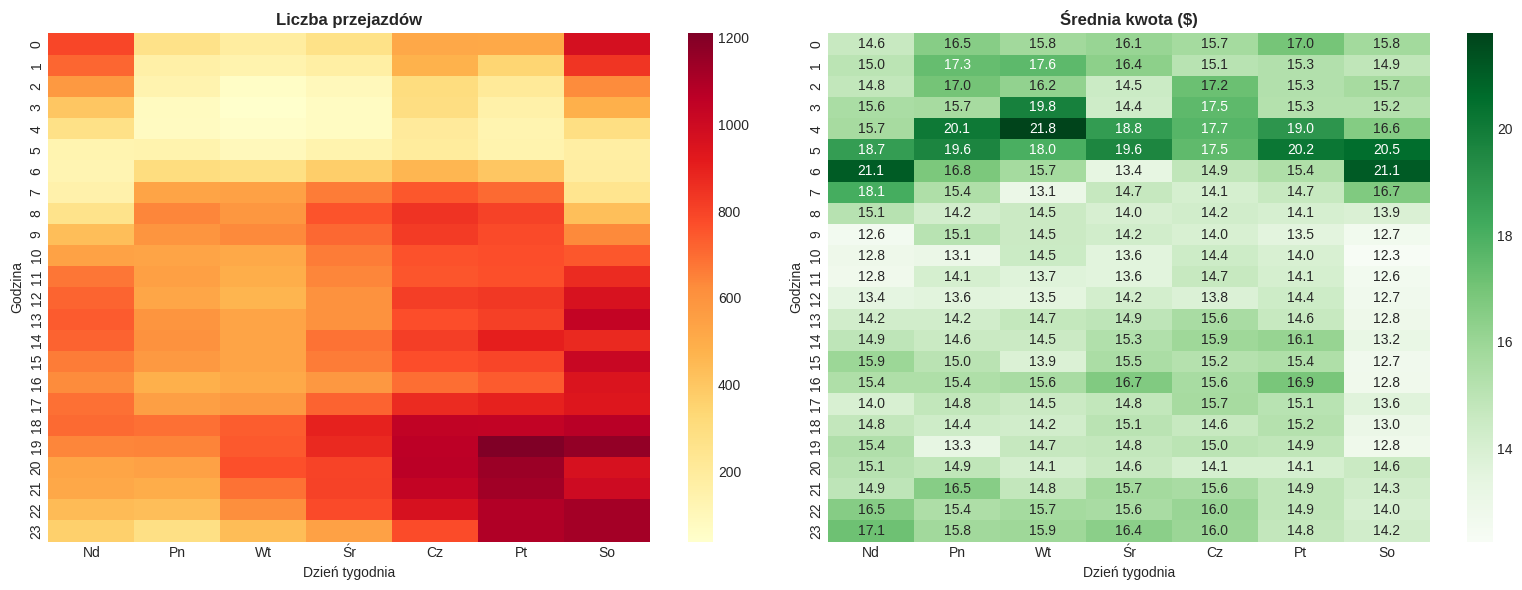

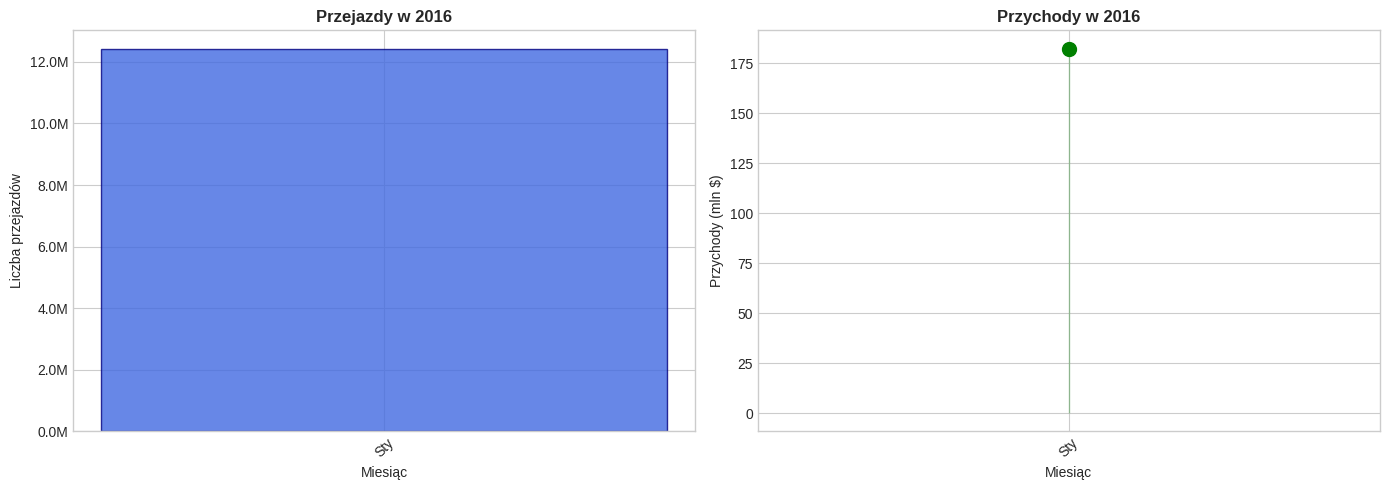

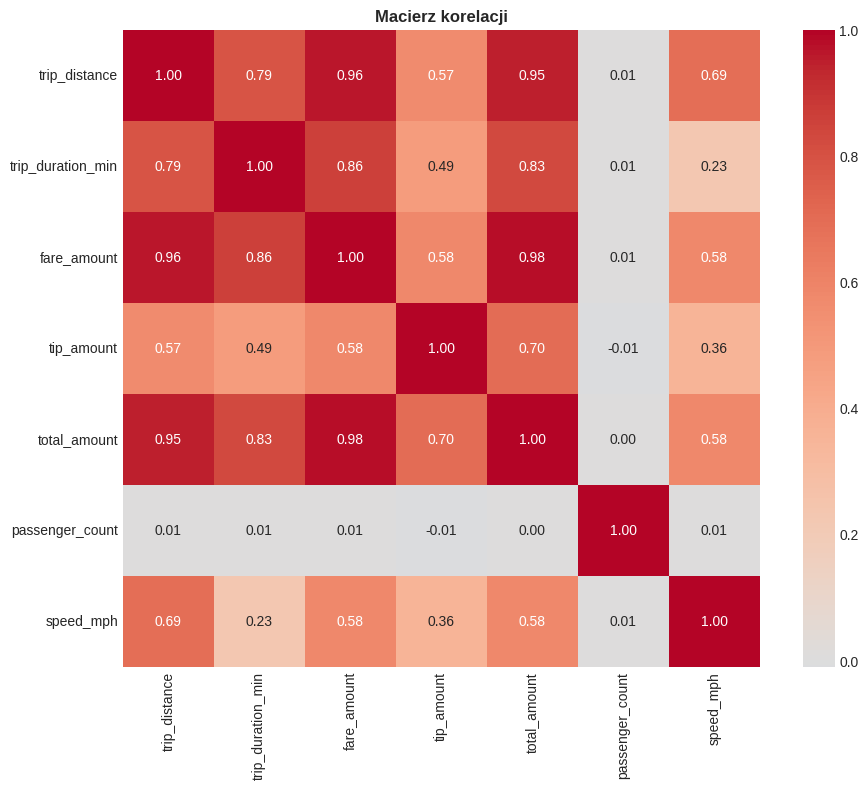


                    PODSUMOWANIE PRZETWARZANIA

1. CZYSZCZENIE:
   - Usunięto 2.59% rekordów
   - Finalnie: 12,401,881 rekordów

2. NOWE CECHY:
   - Czasowe: pickup_hour, pickup_day, is_weekend, is_rush_hour, is_night
   - Przejazdu: trip_duration_min, speed_mph, distance_category
   - Napiwków: tip_percentage, high_tip

3. MongoDB:
   - Zapisano 5 kolekcji agregatów
   - Gotowe do analizy i wizualizacji

4. NASTĘPNY KROK:
   - 03_ml_modeling.ipynb - modelowanie ML


Połączenie MongoDB zamknięte


In [10]:
# %% Przygotowanie próbki
sample_size = 100000
df_sample = df_features.sample(
    fraction=sample_size / final_count, 
    seed=42
).toPandas()
print(f"Próbka do wizualizacji: {len(df_sample):,}")

# %% Wykres 1: Rozkłady po przetworzeniu
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Przejazdy wg godziny
hourly_data = list(db.hourly_stats.find().sort("pickup_hour", 1))
hours = [d["pickup_hour"] for d in hourly_data]
trips = [d["trip_count"] for d in hourly_data]

axes[0, 0].bar(hours, trips, color='steelblue', edgecolor='navy', alpha=0.8)
axes[0, 0].set_xlabel("Godzina")
axes[0, 0].set_ylabel("Liczba przejazdów")
axes[0, 0].set_title("Rozkład przejazdów wg godziny", fontweight='bold')
axes[0, 0].set_xticks(range(0, 24, 2))
axes[0, 0].axvspan(7, 9, alpha=0.2, color='red', label='Rush hour poranny')
axes[0, 0].axvspan(16, 19, alpha=0.2, color='orange', label='Rush hour wieczorny')
axes[0, 0].legend()

# Przejazdy wg dnia
daily_data = list(db.daily_stats.find().sort("pickup_day", 1))
days = [d["day_name"] for d in daily_data]
day_trips = [d["trip_count"] for d in daily_data]
colors = ['#e74c3c' if d in ['Sobota', 'Niedziela'] else '#3498db' for d in days]

axes[0, 1].bar(days, day_trips, color=colors, edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel("Dzień tygodnia")
axes[0, 1].set_ylabel("Liczba przejazdów")
axes[0, 1].set_title("Rozkład przejazdów wg dnia", fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)

# Rozkład prędkości
axes[1, 0].hist(df_sample["speed_mph"].clip(0, 40), bins=40,
                color='forestgreen', edgecolor='darkgreen', alpha=0.8)
axes[1, 0].set_xlabel("Prędkość (mph)")
axes[1, 0].set_ylabel("Liczba")
axes[1, 0].set_title("Rozkład prędkości", fontweight='bold')
axes[1, 0].axvline(df_sample["speed_mph"].median(), color='red',
                   linestyle='--', label=f'Mediana: {df_sample["speed_mph"].median():.1f}')
axes[1, 0].legend()

# Rozkład czasu trwania
axes[1, 1].hist(df_sample["trip_duration_min"].clip(0, 60), bins=40,
                color='darkorange', edgecolor='saddlebrown', alpha=0.8)
axes[1, 1].set_xlabel("Czas trwania (min)")
axes[1, 1].set_ylabel("Liczba")
axes[1, 1].set_title("Rozkład czasu trwania", fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/01_distributions.png', dpi=150)
plt.show()

# %% Wykres 2: Analiza napiwków
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rozkład % napiwków
tip_pct = df_sample[df_sample["tip_percentage"] > 0]["tip_percentage"].clip(0, 50)
axes[0, 0].hist(tip_pct, bins=50, color='purple', edgecolor='indigo', alpha=0.8)
axes[0, 0].set_xlabel("Napiwek (%)")
axes[0, 0].set_ylabel("Liczba")
axes[0, 0].set_title("Rozkład procentowy napiwków", fontweight='bold')
axes[0, 0].axvline(20, color='red', linestyle='--', linewidth=2, 
                   label='Próg wysokiego napiwku')
axes[0, 0].legend()

# Napiwki wg płatności
payment_data = list(db.payment_stats.find())
payment_names = [d["payment_name"] for d in payment_data]
avg_tips = [d["avg_tip"] for d in payment_data]

bars = axes[0, 1].bar(payment_names, avg_tips, 
                       color=['#2ecc71', '#e74c3c', '#9b59b6', '#f39c12'],
                       edgecolor='black', alpha=0.8)
axes[0, 1].set_xlabel("Typ płatności")
axes[0, 1].set_ylabel("Średni napiwek ($)")
axes[0, 1].set_title("Napiwki wg typu płatności", fontweight='bold')
for bar, val in zip(bars, avg_tips):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
                    f'${val:.2f}', ha='center', fontsize=10)

# Napiwki wg godziny
tip_by_hour = [d["avg_tip_pct"] for d in hourly_data]
axes[1, 0].plot(hours, tip_by_hour, marker='o', linewidth=2,
                color='darkblue', markersize=6)
axes[1, 0].fill_between(hours, tip_by_hour, alpha=0.3)
axes[1, 0].set_xlabel("Godzina")
axes[1, 0].set_ylabel("Średni napiwek (%)")
axes[1, 0].set_title("Napiwki wg godziny", fontweight='bold')
axes[1, 0].set_xticks(range(0, 24, 2))
axes[1, 0].axhline(y=20, color='red', linestyle='--', alpha=0.7)

# Proporcja wysokich napiwków
high_tip_rate = [d["high_tip_rate"] for d in hourly_data]
axes[1, 1].bar(hours, high_tip_rate, color='teal', edgecolor='darkcyan', alpha=0.8)
axes[1, 1].set_xlabel("Godzina")
axes[1, 1].set_ylabel("Odsetek wysokich napiwków (%)")
axes[1, 1].set_title("Odsetek wysokich napiwków (>20%)", fontweight='bold')
axes[1, 1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig('../reports/figures/02_tips_analysis.png', dpi=150)
plt.show()

# %% Wykres 3: Heatmapy
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmapa przejazdów
pivot_trips = df_sample.pivot_table(
    values="total_amount",
    index="pickup_hour",
    columns="pickup_day",
    aggfunc="count"
)
pivot_trips.columns = ['Nd', 'Pn', 'Wt', 'Śr', 'Cz', 'Pt', 'So']

sns.heatmap(pivot_trips, cmap="YlOrRd", ax=axes[0])
axes[0].set_xlabel("Dzień tygodnia")
axes[0].set_ylabel("Godzina")
axes[0].set_title("Liczba przejazdów", fontweight='bold')

# Heatmapa kwoty
pivot_amount = df_sample.pivot_table(
    values="total_amount",
    index="pickup_hour",
    columns="pickup_day",
    aggfunc="mean"
)
pivot_amount.columns = ['Nd', 'Pn', 'Wt', 'Śr', 'Cz', 'Pt', 'So']

sns.heatmap(pivot_amount, annot=True, fmt=".1f", cmap="Greens", ax=axes[1])
axes[1].set_xlabel("Dzień tygodnia")
axes[1].set_ylabel("Godzina")
axes[1].set_title("Średnia kwota ($)", fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/03_heatmaps.png', dpi=150)
plt.show()

# %% Wykres 4: Trendy miesięczne
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

monthly_data = list(db.monthly_stats.find().sort("pickup_month", 1))
months = [d["pickup_month"] for d in monthly_data]
month_trips = [d["trip_count"] for d in monthly_data]
month_revenue = [d["total_revenue"] / 1e6 for d in monthly_data]

# Liczba przejazdów
axes[0].bar(MONTH_NAMES[:len(months)], month_trips, 
            color='royalblue', edgecolor='navy', alpha=0.8)
axes[0].set_xlabel("Miesiąc")
axes[0].set_ylabel("Liczba przejazdów")
axes[0].set_title("Przejazdy w 2016", fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))

# Przychody
axes[1].plot(MONTH_NAMES[:len(months)], month_revenue, marker='o', 
             linewidth=3, markersize=10, color='green')
axes[1].fill_between(MONTH_NAMES[:len(months)], month_revenue, alpha=0.3, color='green')
axes[1].set_xlabel("Miesiąc")
axes[1].set_ylabel("Przychody (mln $)")
axes[1].set_title("Przychody w 2016", fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../reports/figures/04_monthly_trends.png', dpi=150)
plt.show()

# %% Wykres 5: Korelacje
fig, ax = plt.subplots(figsize=(10, 8))

corr_cols = ["trip_distance", "trip_duration_min", "fare_amount",
             "tip_amount", "total_amount", "passenger_count", "speed_mph"]
corr_matrix = df_sample[corr_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            center=0, square=True, ax=ax)
ax.set_title("Macierz korelacji", fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/figures/05_correlation.png', dpi=150)
plt.show()

# %% [markdown]
# ## 2.6 Zapisanie Przetworzonego DataFrame

# %% Zapisanie do formatu Parquet (opcjonalnie)
# df_features.write.parquet('/home/jovyan/data/processed/taxi_2016_features', mode='overwrite')
# print("Dane zapisane do Parquet")

# %% Podsumowanie
print("""
================================================================================
                    PODSUMOWANIE PRZETWARZANIA
================================================================================

1. CZYSZCZENIE:
   - Usunięto {:.2f}% rekordów
   - Finalnie: {:,} rekordów

2. NOWE CECHY:
   - Czasowe: pickup_hour, pickup_day, is_weekend, is_rush_hour, is_night
   - Przejazdu: trip_duration_min, speed_mph, distance_category
   - Napiwków: tip_percentage, high_tip

3. MongoDB:
   - Zapisano 5 kolekcji agregatów
   - Gotowe do analizy i wizualizacji

4. NASTĘPNY KROK:
   - 03_ml_modeling.ipynb - modelowanie ML

================================================================================
""".format(
    stats['removed_pct'],
    final_count
))

# %% Zamknięcie połączenia MongoDB
client.close()
print("Połączenie MongoDB zamknięte")